# Imports

In [1]:
import warnings
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold

from dstoolkit.automl.classifier import AutoMLCatBoost, AutoMLCatBoostCV
from dstoolkit.metrics import plots
from dstoolkit.model import interpretability 

/home/junior/Documentos/GitHub/data-science-toolkit/venv/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
warnings.filterwarnings("ignore")

## Functions

In [3]:
def generate_synthetic_binary_data(
    n_samples=10000,
    n_features=30,
    n_informative=5,
    n_redundant=10,
    n_repeated=0,
    n_classes=2,
    class_sep=0.5,
    flip_y=0.15,
    weights=[0.8, 0.2],
    test_size=0.2,
    valid_size=0.2,
    random_state=42
):
    """
    Gera uma base sintética binária com splits train/valid/test.
    Retorna: (X_train, y_train, X_valid, y_valid, X_test, y_test)
    """

    # ---------------------------
    # 1. Gerar base sintética
    # ---------------------------
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_informative,
        n_redundant=n_redundant,
        n_repeated=n_repeated,
        n_classes=n_classes,
        class_sep=class_sep,
        flip_y=flip_y,
        weights=weights,
        random_state=random_state
    )

    # ---------------------------
    # 2. Train/Test
    # ---------------------------
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        stratify=y,
        random_state=random_state
    )

    # ---------------------------
    # 3. Train/Validation
    # ---------------------------
    valid_relative = valid_size / (1 - test_size)

    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, y_train,
        test_size=valid_relative,
        stratify=y_train,
        random_state=random_state
    )

    y_train = pd.DataFrame(y_train, columns=['target'])
    y_valid = pd.DataFrame(y_valid, columns=['target'])
    y_test = pd.DataFrame(y_test, columns=['target'])
    
    return pd.DataFrame(X_train), y_train, pd.DataFrame(X_valid), y_valid, pd.DataFrame(X_test), y_test

# Database

In [4]:
X_train, y_train, X_valid, y_valid, X_test, y_test = generate_synthetic_binary_data(
    n_samples=5000,
    n_features=30,
    n_informative=5,
    n_redundant=10,
    n_repeated=0,
    n_classes=2,
    class_sep=0.5,   # classes mais misturadas
    flip_y=0.15,     # ruído nos rótulos
    weights=[0.8, 0.2],  # desbalanceamento
    test_size=0.2,
    valid_size=0.2,
    random_state=42
)

# Modeling

In [5]:
cat = AutoMLCatBoost(scoring='log_loss', tune=True, n_trials=20)
cat.train(X_train, y_train, X_valid, y_valid, X_test, y_test)

In [6]:
model = cat.model

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def plot_feature_importance(model, top_n=20, figsize=None, ax=None):
    """
    Plot feature importance for tree-based models.

    This function visualizes the most important features of a fitted
    tree-based model (e.g., LightGBM, XGBoost, CatBoost, RandomForest),
    helping to understand which variables contribute most to the model's
    predictions.

    Parameters
    ----------
    model : estimator object
        A fitted model that exposes feature importance information through
        either a `feature_importances_` attribute or a `get_score` method
        (XGBoost native models).

    top_n : int, default=20
        Number of top features to display, ordered by importance.

    figsize : tuple, optional
        Size of the matplotlib figure. Used only if `ax` is None.
        If None, the height is automatically adjusted based on `top_n`.

    ax : matplotlib.axes.Axes, optional
        Axes object to draw the plot onto. If None, a new figure and axes
        are created.

    Returns
    -------
    fig : matplotlib.figure.Figure
        The matplotlib figure object.

    ax : matplotlib.axes.Axes
        The matplotlib axes object containing the plot.

    Raises
    ------
    AttributeError
        If feature names or feature importance values cannot be inferred
        from the model.

    Notes
    -----
    - Feature importances are model-specific and should not be interpreted
      as causal effects.
    - Importance values from different models or training runs are not
      directly comparable.
    """

    # --- Feature names ---
    if hasattr(model, "feature_name_"):
        feature_names = model.feature_name_
    elif hasattr(model, "feature_names_"):
        feature_names = model.feature_names_
    elif hasattr(model, "feature_names_in_"):
        feature_names = model.feature_names_in_
    else:
        raise AttributeError("Unable to infer feature names from the model.")

    # --- Feature importances ---
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
    elif hasattr(model, "get_score"):  # XGBoost native API
        importance_dict = model.get_score(importance_type="weight")
        feature_names = np.array(list(importance_dict.keys()))
        importances = np.array(list(importance_dict.values()))
    else:
        raise AttributeError("The provided model does not expose feature importance information.")

    # --- Prepare data ---
    df_imp = (
        pd.DataFrame(
            {
                "Feature": feature_names, 
                "Importance": importances
            }
        )
        .sort_values("Importance", ascending=False)
        .head(top_n)
    )

    # --- Axes / Figure ---
    if ax is None:
        if figsize is None:
            figsize = (8, max(4, top_n * 0.4))
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.figure

    # --- Plot ---
    ax.barh(
        df_imp["Feature"][::-1],
        df_imp["Importance"][::-1],
        color="tab:blue",
        alpha=0.85,
    )

    ax.set_xlabel("Importance")
    ax.set_ylabel("Feature")
    ax.set_title("Feature Importance")
    ax.grid(axis="x", alpha=0.3)

    fig.tight_layout()

    return fig, ax

(<Figure size 800x800 with 1 Axes>,
 <Axes: title={'center': 'Feature Importance'}, xlabel='Importance', ylabel='Feature'>)

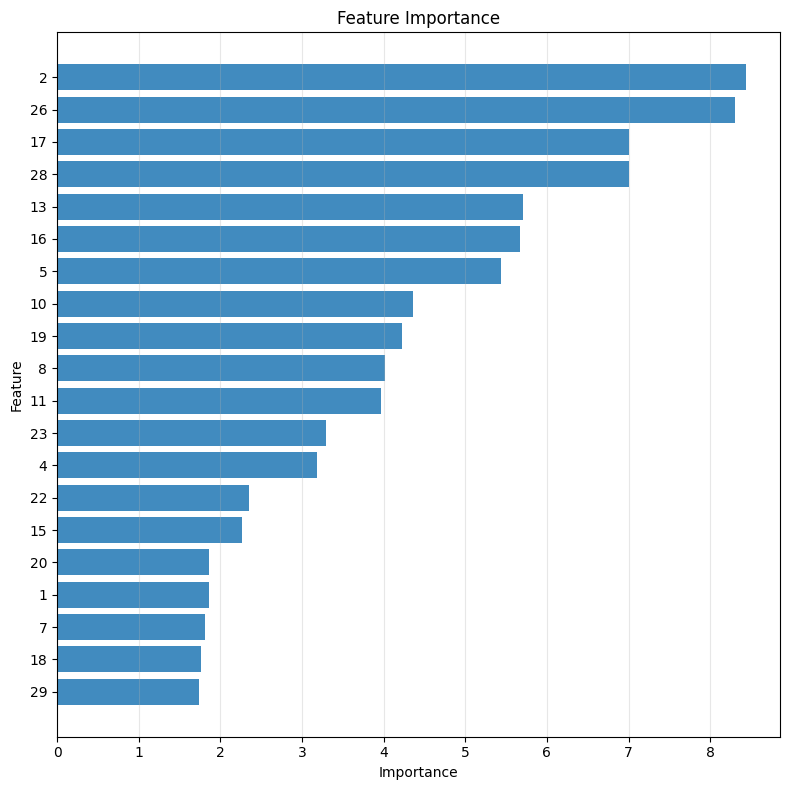

In [13]:
interpretability.plot_feature_importance(model)

(<Figure size 800x1200 with 1 Axes>,
 <Axes: title={'center': 'Permutation Feature Importance'}, xlabel='Decrease in roc_auc'>)

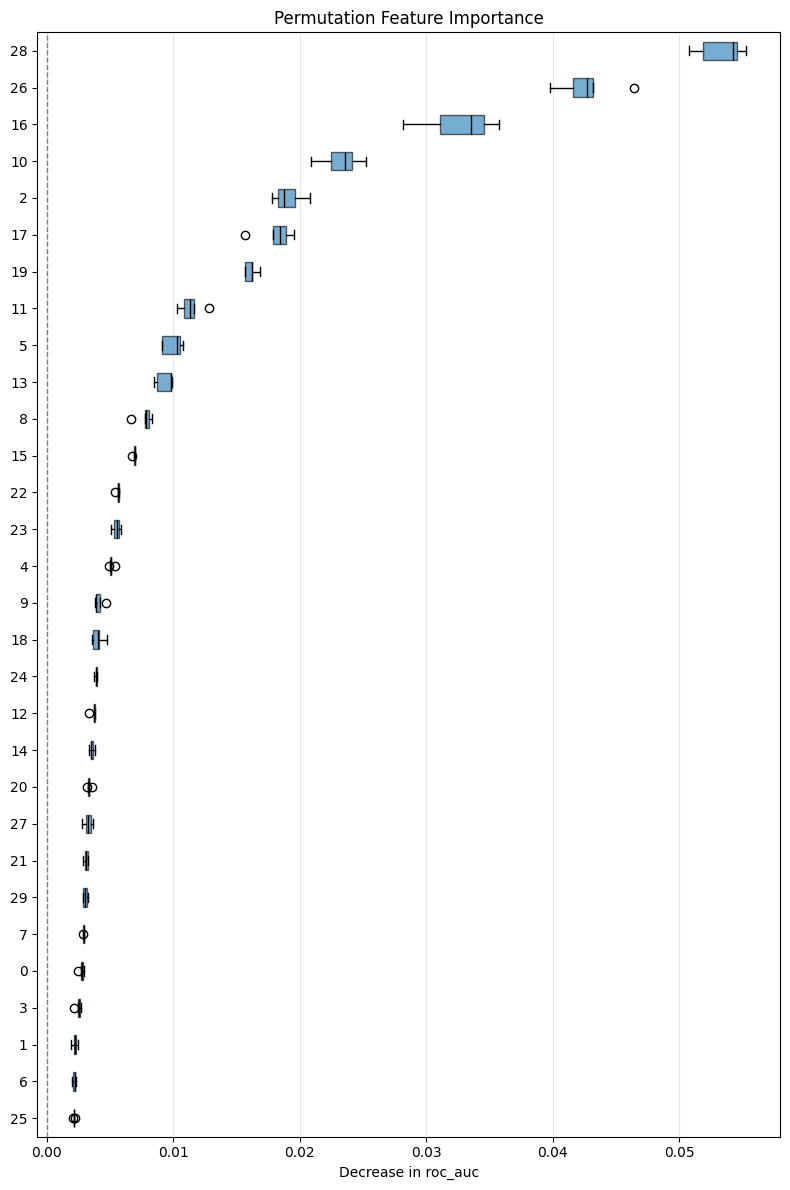

In [15]:
interpretability.plot_permutation_importance(model, X_train, y_train['target'], scoring='roc_auc')

(<Figure size 800x950 with 2 Axes>,
 <Axes: xlabel='SHAP value (impact on model output)'>)

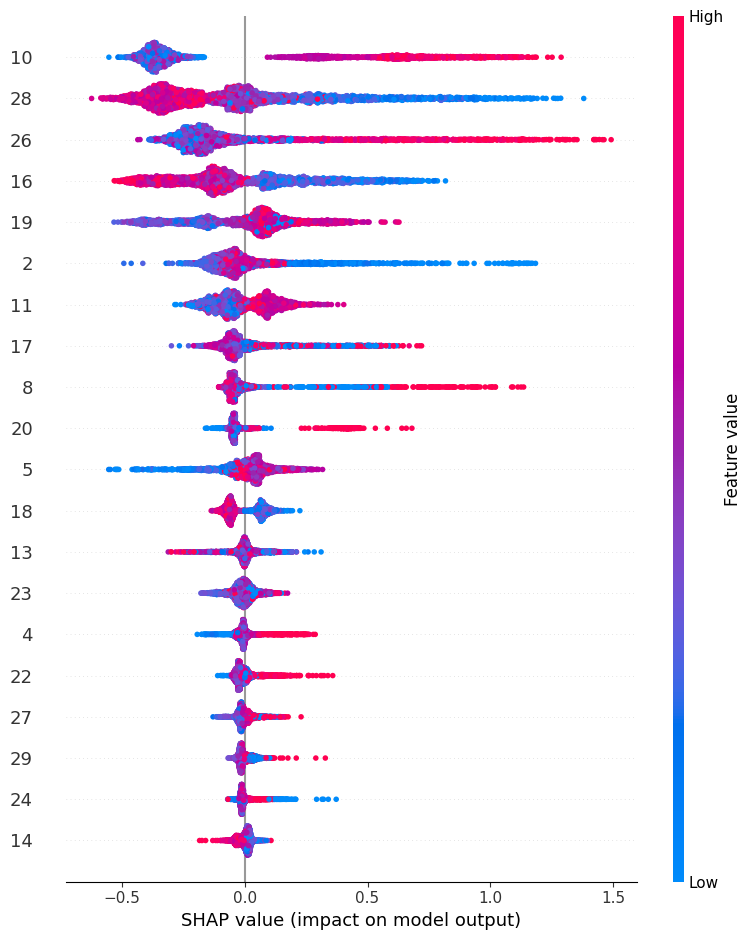

In [16]:
interpretability.plot_shap_tree_summary(model, X_train)